In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Resampled_Training_Data.csv to Resampled_Training_Data.csv


In [ ]:
import pandas as pd

df = pd.read_csv('Resampled_Training_Data.csv')
df.head()

,SeniorCitizen,tenure,MonthlyCharges,gender_1,Dependents_1,PhoneService_1,MultipleLines_1,InternetService_1,Contract_1,Contract_2,Churn_1
0,0,0.888889,0.900990,1,1,1,0,0,1,0,0
1,0,0.416667,0.019802,1,0,1,1,1,0,1,1
2,0,0.069444,0.752475,1,0,1,0,0,0,0,0
3,0,0.944444,0.900990,0,1,1,0,1,0,0,0
4,0,0.125000,0.267327,1,0,0,1,0,0,1,0


Reloading Tuner from tuner_dir/churn_ann_tuning/tuner0.json
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6342 - loss: 0.6711 - val_accuracy: 0.6222 - val_loss: 0.6778
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6431 - loss: 0.6658 - val_accuracy: 0.6172 - val_loss: 0.6782
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6554 - loss: 0.6572 - val_accuracy: 0.6188 - val_loss: 0.6776
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6522 - loss: 0.6608 - val_accuracy: 0.6360 - val_loss: 0.6688
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6365 - loss: 0.6643 - val_accuracy: 0.6327 - val_loss: 0.6723
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6449 - loss: 0.6637 - val_accuracy: 0.6355 - val_loss: 0.6751
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6394 - loss: 0.6638 - val_accuracy: 0.6199 - val_loss: 0.6796
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6389 - loss: 0.6650 - val_accuracy: 0.6255 - val

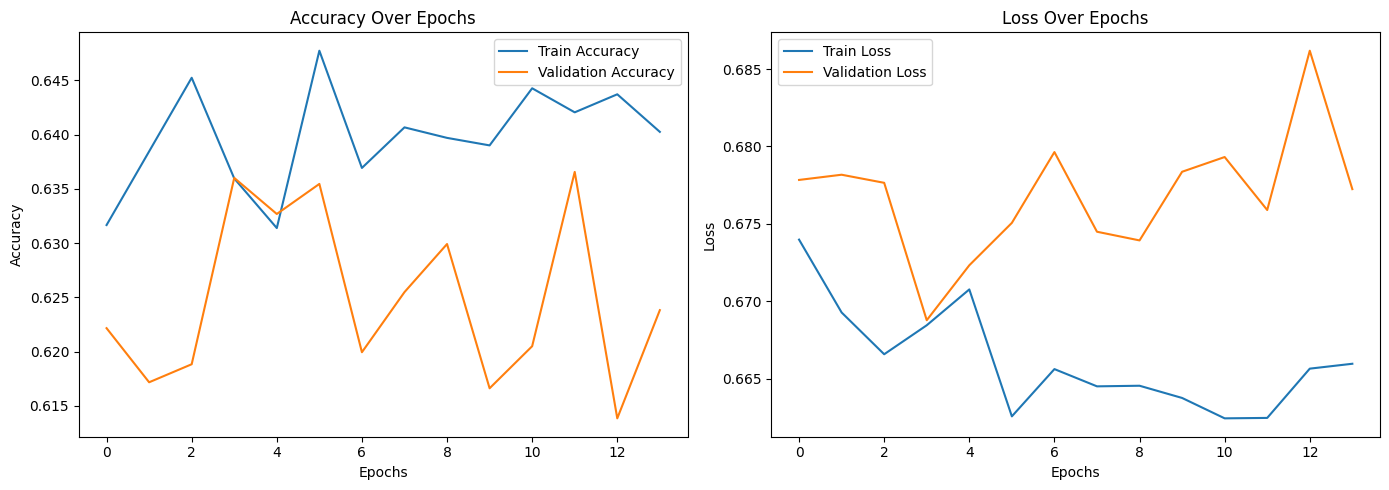

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


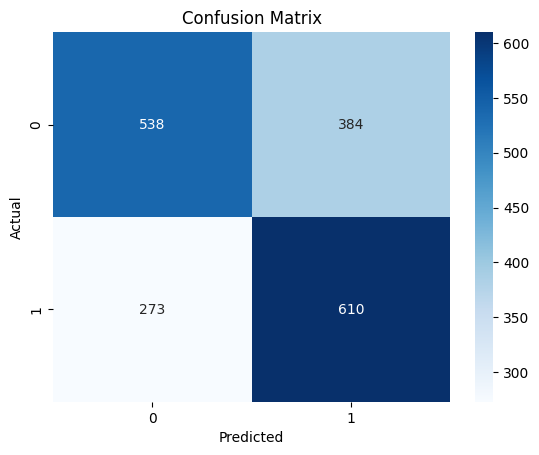

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.58      0.62       922
           1       0.61      0.69      0.65       883

    accuracy                           0.64      1805
   macro avg       0.64      0.64      0.64      1805
weighted avg       0.64      0.64      0.64      1805

AUC Score: 0.6939


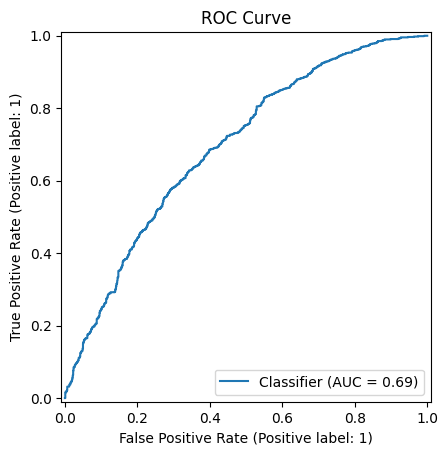

In [37]:
!pip install keras-tuner --quiet
# -------------------------------
# Import Required Libraries
# -------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.utils import class_weight

import keras_tuner as kt  # For hyperparameter tuning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# -------------------------------
# Load and Prepare the Data
# -------------------------------

# Load the dataset
df = pd.read_csv("Resampled_Training_Data.csv")

# Separate features and target
X = df.drop("Churn_1", axis=1)
y = df["Churn_1"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Handle class imbalance using class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# -------------------------------
# Define Model Builder Function for Tuning
# -------------------------------
def build_model(hp):
    model = Sequential()

    # Input layer using Input() instead of input_dim (recommended practice)
    model.add(Input(shape=(X_train.shape[1],)))

    # First Dense layer
    model.add(Dense(
        units=hp.Int('units_input', 64, 512, step=64),
        kernel_regularizer=l2(hp.Choice('l2_input', [0.001, 0.01, 0.1]))
    ))
    model.add(LeakyReLU(negative_slope=0.01))  # Updated: alpha → negative_slope
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_input', 0.2, 0.5, step=0.1)))

    # Additional Hidden Layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', 32, 256, step=32),
            kernel_regularizer=l2(hp.Choice(f'l2_{i}', [0.001, 0.01, 0.1]))
        ))
        model.add(LeakyReLU(negative_slope=0.01))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 5e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# -------------------------------
# Run Hyperparameter Tuning
# -------------------------------
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of different model combinations to try
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='churn_ann_tuning'
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# Start the tuning search
tuner.search(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)

# -------------------------------
# Evaluate the Best Model
# -------------------------------
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model further
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weights_dict,
    verbose=1
)

# -------------------------------
# Visualize Training Results
# -------------------------------
plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# -------------------------------
# Model Predictions and Evaluation
# -------------------------------
# Predict probabilities and convert to binary predictions
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# AUC score and ROC curve
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc:.4f}")
RocCurveDisplay.from_predictions(y_test, y_pred_prob)
plt.title("ROC Curve")
plt.show()